# Important Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [2]:

# the SEIR model differential equations
def deriv(t, y, N, beta, sigma, gamma, delta):
    S, E, I, R, D = y
    dSdt = -beta * S * I / (N-D)
    dEdt = beta * S * I / (N-D) - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [3]:
# theotal population we are modeling -  N
N = 1000
# the initial number of infected and recovered individuals in our data
I0, R0 = 1, 0
# the initial number of exposed individuals in our data
E0 = 0
# the initial number of folk dead from the disease is zero
D0 = 0
# everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - E0 - D0
# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta, sigma, gamma, delta = 0.3, 1/5.2, 1/10, 1/150
# the time points (days) over which we want to predict using our model
t = np.linspace(0, 160, 160)

# here we set the initial conditions vector
y0 = S0, E0, I0, R0, D0

In [4]:

# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 160], y0, args=(N, beta, sigma, gamma, delta), t_eval=t)

# extract the results
S, E, I, R, D = sol.y

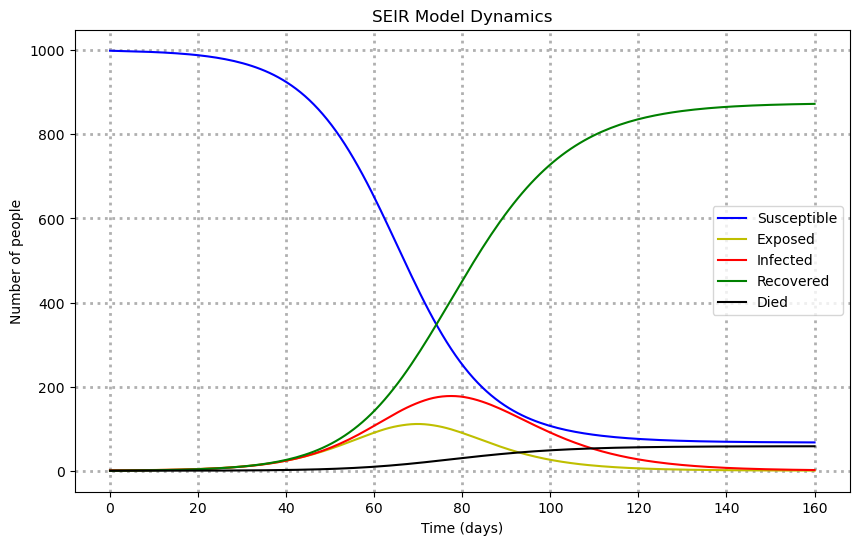

In [5]:
# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, E, 'y', label='Exposed')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(t, D, 'k', label='Died')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Number of people")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



In [13]:
# the SEIR model differential equations
def deriv_matrix(t, # irrelevant as t is not used explicitly 
                 Y: npt.NDArray, 
                 beta_vector: npt.ArrayLike,
                 gamma: float, 
                 delta: float,
                 latent_period: float,
                 theta_matrix: npt.NDArray) -> np.array:
    """
    Takes the parameters and state matrix $Y$ and computes the derivative dYdt

    Args:
      Y (np.array): 
        The state matrix. This says the population in each compartment (S,I,R, and D), 
        for each type of population (e.g. old, young). Should be input as a flattened matrix.  
      beta_vector (np.array/list):
        The infection coefficient for each population's environment. Units of /day
        [beta_1, beta_2, ..., beta_M] where M is the number of types of mixing environment (e.g. party, non-party).
      gamma (float):
        the recovery rate in /day
      delta (float):
        the death rate in /day
      theta_matrix (npt.NDArray):
        MxN matrix, where M is the number of mixing environments and N is the number of types of population
        The matrix encodes the portion of people of type i who visit environment j in the timestep. 
        can be thought of as a probability. Probability is independent of the compartment state (S,I,and R all visit),
        Dead folk don't visit. 
      latent_period (float):
        the average length of time in days between exposure and the beginning of infectiousness. Fixed at 1.4 days. 

    Returns:
      dYdt (np.array): 
        A flattened array of the same dimensions as Y, corresponding to dY/dt (the change in Y for 1 day). 
    """
    Y_matrix = Y.reshape(int(Y.size/5), 5)

    S, E, I, R, D = Y_matrix.T
    
    B_env_matrix = np.matmul(theta_matrix, Y_matrix)

    S_env, E_env, I_env, R_env, D_env = B_env_matrix.T
    
    N_active_env = S_env + E_env + I_env + R_env  # just adds S, I, and R

    N_active_env[np.isclose(N_active_env,0)]=1
    # The vulnerable matrix ---- says which
    
    dYdt = np.zeros(Y_matrix.shape)
    
    new_infections_by_pop = np.zeros(len(S))
    
    #for i, s_i in enumerate(S):
    #    new_infections_by_pop[i] = np.matmul(s_i * theta_matrix.T[i] , beta_vector * I_env / N_active_env)
    new_infections_by_pop = np.matmul( np.multiply(S, theta_matrix).T , beta_vector * I_env / N_active_env)
    
    dYdt = np.array([-new_infections_by_pop,
                     new_infections_by_pop - E / latent_period,
                     E / latent_period - I*(gamma+delta), 
                     gamma*I,  
                     delta*I]).T

    return dYdt.flatten()

Creates the `theta_matrix` in a standardised way from an array of arguments 

In [14]:
def build_theta_matrix(*args) -> npt.NDArray:
    """Builds the theta matrix from a series of arguments. 

    Args:
      The parameters that go into the theta matrix. 

    Returns:
      theta_matrix (npt.NDArray): 
        The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
        Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
    """
    theta_matrix = np.array([[   args[0],    args[1],    args[1]],
                             [1.-args[0], 1.-args[1], 1.-args[1]]])
    return theta_matrix

In [15]:
def simple_error_checks(Y_matrix_0, beta_vector, gamma, delta, theta_matrix):
    """Performs some checks that the shape and content of various NDarrays are what they should be. 
    """
    if not theta_matrix.shape == (len(beta_vector), Y_matrix_0.shape[0]):
        raise Exception("theta_matrix is not M by N, where M is the number of environments = length of the beta_vector and N is the number of populations")
    if not np.array_equal(theta_matrix.sum(axis=0), np.ones(Y_matrix_0.shape[0])):
        raise Exception("the theta_matrix isn't properly normalized (all columns should add to one)")

### Setting the parameters for an example coupled SEIRD model

In [16]:
# The SIRD matrix on the first day of infection
Y_matrix_0 = np.array([[599000, 0, 100, 0, 0],
                       [400000, 0, 0, 0, 0],
                       [500000, 0, 0, 0, 0]])

# The total number of people in each population
N_vector = Y_matrix_0.sum(axis=1)

# the contact rate, beta, for each population
beta_vector = np.array([0.3, 0.2])
# The incubation_rate, recovery rate and death rate
latent_period, gamma, delta = 1.4, 0.15, 0.015

# the coupling matrix between the boxes. 
theta_matrix = build_theta_matrix( 0.9, 0.2)

print("Number of populations = {}\n".format(len(beta_vector)))
print(" Starting vector S,E,I,R,D for each population = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix)

# Do some simple error checks
simple_error_checks(Y_matrix_0, beta_vector, gamma, delta, theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector S,E,I,R,D for each population = 
 [[599000      0    100      0      0]
 [400000      0      0      0      0]
 [500000      0      0      0      0]]

Parameters:
 beta_vector =  [0.3 0.2]
 gamma = 0.15,
 delta = 0.015,

 latent period = 1.4,

 theta_matrix = 
 [[0.9 0.2 0.2]
 [0.1 0.8 0.8]]


Ready to go!


In [17]:
# Now we use scipy to solve the system of differential equations
solmat = solve_ivp(deriv_matrix, 
                   [0, 400], 
                   Y_matrix_0.flatten(), 
                   args=(beta_vector, gamma, delta, latent_period, theta_matrix), 
                   t_eval=t)

solmat

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.001e-02 ...  3.999e+02  4.000e+02]
        y: [[ 5.990e+05  5.990e+05 ...  1.836e+05  1.836e+05]
            [ 0.000e+00  9.977e-01 ...  2.071e-03  2.065e-03]
            ...
            [ 0.000e+00  1.054e-05 ...  2.524e+05  2.524e+05]
            [ 0.000e+00  1.054e-06 ...  2.524e+04  2.524e+04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 716
     njev: 0
      nlu: 0

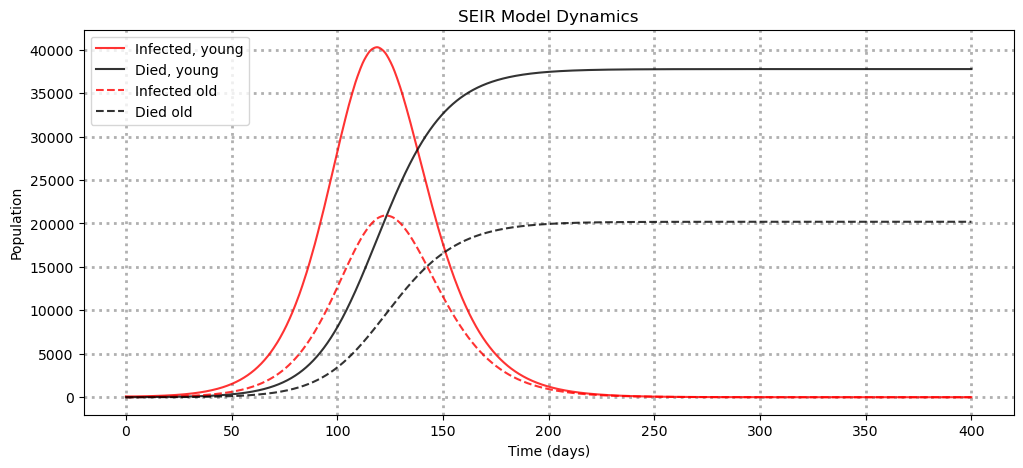

In [18]:
Y_t = solmat.y.reshape(*Y_matrix_0.shape,len(t))

S_plot, E_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, E_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

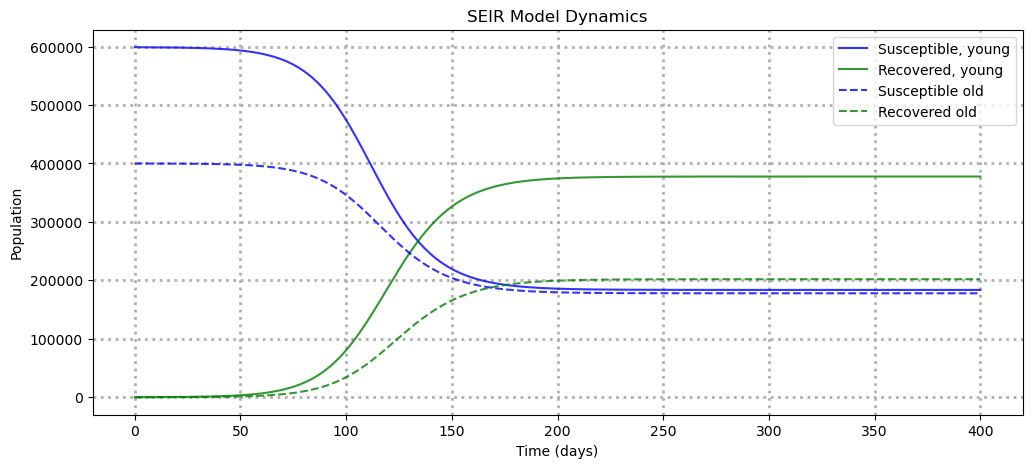

In [19]:
Y_t = solmat.y.reshape(*Y_matrix_0.shape,len(t))

S_plot, E_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, E_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

### Generating data for fitting

Generate some sparse data with a little noise. This is for fitting tests later.

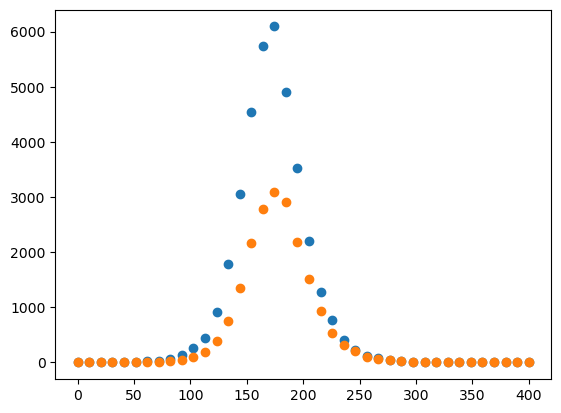

In [20]:
t_sparse = np.linspace(0,400, 40)
solmat_fake = solve_ivp(deriv_matrix, 
                        [0, 400], 
                        Y_matrix_0.flatten(), 
                        args=(beta_vector, gamma, delta, latent_period, theta_matrix), 
                        t_eval=t_sparse)


Y_sparse = solmat_fake.y.reshape(*Y_matrix_0.shape,len(t_sparse)).transpose((2,0,1))
my_sparse_derivs = np.zeros(Y_sparse.shape)
for i,yt in enumerate(Y_sparse):
    my_sparse_derivs[i] = deriv_matrix(t,
                                       yt.flatten(),
                                       beta_vector,
                                       gamma,
                                       delta,
                                       latent_period,
                                       theta_matrix).reshape(yt.shape)

from numpy.random import poisson

fake_deaths_per_day = poisson(my_sparse_derivs.T[3])
#fake_deaths_per_day = my_sparse_derivs.T[3]


shifted_fake_deaths_per_day = np.concatenate([np.zeros((3,5)), fake_deaths_per_day[:,0:35]],axis=1)
shifted_fake_deaths_per_day.shape

plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], label='Sparse Old Deaths per Day')

# 2D version fitting

Going to generate data from the 2D version and fit that. 

In [22]:
# the SEIR model differential equations
def deriv_matrix(t, # irrelevant as t is not used explicitly 
                 Y: npt.NDArray, 
                 betha_vector: npt.NDArray,
                 gamma: float, 
                 delta: float,
                 latent_period: float,
                 theta_matrix: npt.NDArray) -> np.array:
    """
    Takes the parameters and state matrix $Y$ and computes the derivative dYdt

    Args:
      Y (np.array): 
        The state matrix. This says the population in each compartment (S,I,R, and D), 
        for each type of population (e.g. old, young). Should be input as a flattened matrix.  
      beta_vector (np.array/list):
        The infection coefficient for each population's environment. Units of /day
        [beta_1, beta_2, ..., beta_M] where M is the number of types of mixing environment (e.g. party, non-party).
      gamma (float):
        the recovery rate in /day
      delta (float):
        the death rate in /day
      theta_matrix (npt.NDArray):
        MxN matrix, where M is the number of mixing environments and N is the number of types of population
        The matrix encodes the portion of people of type i who visit environment j in the timestep. 
        can be thought of as a probability. Probability is independent of the compartment state (S,I,and R all visit),
        Dead folk don't visit. 
      latent_period (float):
        the average length of time in days between exposure and the beginning of infectiousness. Fixed at 1.4 days. 

    Returns:
      dYdt (np.array): 
        A flattened array of the same dimensions as Y, corresponding to dY/dt (the change in Y for 1 day). 
    """
    Y_matrix = Y.reshape(int(Y.size/5), 5)

    S, E, I, R, D = Y_matrix.T
    
    B_env_matrix = np.matmul(theta_matrix, Y_matrix)

    S_env, E_env, I_env, R_env, D_env = B_env_matrix.T
    
    N_active_env = S_env + E_env + I_env + R_env  # just adds S, I, and R

    N_active_env[np.isclose(N_active_env,0)]=1
    # The vulnerable matrix ---- says which
    
    dYdt = np.zeros(Y_matrix.shape)
    
    new_infections_by_pop = np.zeros(len(S))
    
    #for i, s_i in enumerate(S):
    #    new_infections_by_pop[i] = np.matmul(s_i * theta_matrix.T[i] , beta_vector * I_env / N_active_env)
    new_infections_by_pop = np.matmul( np.multiply(S, betha_matrix).T , I_env / N_active_env)
    
    dYdt = np.array([-new_infections_by_pop,
                     new_infections_by_pop - E / latent_period,
                     E / latent_period - I*(gamma+delta), 
                     gamma*I,  
                     delta*I]).T

    return dYdt.flatten()

In [23]:
def build_betha_matrix(*args) -> npt.NDArray:
    """Builds the theta matrix from a series of arguments. 

    Args:
      The parameters that go into the theta matrix. 

    Returns:
      theta_matrix (npt.NDArray): 
        The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
        Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
    """
    betha = np.array([[   args[0],    args[1],    args[1]],
                      [args[2], args[3], args[3]]])
    return betha

In [24]:
def compute_derivs_per_day(dates: npt.ArrayLike,
                           date_of_first_infection: float,
                           Y_0: npt.NDArray,
                           beta_vector: npt.ArrayLike,
                           gamma: float,
                           delta: float,
                           latent_period: float,
                           theta_matrix: npt.NDArray) -> npt.NDArray:
    """Compute the derivatives dY/dt for a series of dates.

    Args:
      dates (npt.ArrayLike):
        The days on which to evaluate the rate of change of the compartments. 
      date_of_first_infection (float): 
        The date on which infected individuals are first introduced. 
      Y_0 (np.ndarray):
        The distribution of population across all compartments on the first day of infection. 
      beta_vector (npt.ArrayLike):
        The transmission rate for each mixing environment. Length M where M is the number of mixing environments. 
      gamma (float):
        The recovery rate
      delta (float): 
        The death rate
      latent_period (float):
        The mean length of time between exposure and becoming infectious. 
      theta_matrix (np.ndarray):
        MxN array where M is the number of mixing environments, and N is the number of population groups. 
        Theta^i_j encodes the probability of each population type j going to mixing environment i. 

    Returns:
      derivs_for_all_days (np.ndarray):
        Derivatives for the compartments across a series of days. 
        An array with the same number of elements as the compartments multiplied 
        by the number of days. (Nx5xT) where N is the number of population groups, 
        5 is the number of compartments (S,E,I,R,& D), and T is the number of dates. 
    """
    
    dates_after_start = dates[dates >= date_of_first_infection]-date_of_first_infection
    dates_before_start = dates[dates < date_of_first_infection]
    
    # Now we use scipy to solve the system of differential equations
    solmat = solve_ivp(deriv_matrix, 
                   [min(dates_after_start), max(dates_after_start)], 
                   Y_0.flatten(), 
                   args=(beta_vector, gamma, delta, latent_period, theta_matrix), 
                   dense_output=True)
    
    
    Y_t = solmat.sol(dates_after_start).reshape(*Y_0.shape,len(dates_after_start)).transpose((2,0,1))
    
    derivs_post_day_0 = np.zeros(Y_t.shape)
    for i, y_day in enumerate(Y_t):
        derivs_post_day_0[i] = deriv_matrix(dates_after_start, 
                                            y_day, 
                                            beta_vector, 
                                            gamma, 
                                            delta,
                                            latent_period,
                                            theta_matrix).reshape(Y_0.shape)

    derivs_for_all_days = np.concatenate([np.zeros((len(dates_before_start),*Y_0.shape)), np.array(derivs_post_day_0)],
                                         axis=0).transpose((1,2,0))    
    
    return derivs_for_all_days # Return only the death data  


In [229]:
def fitting_function_matrix(dates: npt.ArrayLike,
                            date_of_first_infection: float,
                            beta_young: float,
                            beta_old: float,
                            theta_yo: float,
                            theta_oy: float,
                            gamma: float,
                            delta: float,
                            latent_period: float,
                            Y_0: npt.NDArray) -> np.ndarray:
    """Constructs the input matrices/vectors out of the individual parameters. 

    Args:
       params: All parameters required to find the deaths-per-day (or whatever is being fitted).

    Returns:
      deaths_per_day (np.ndarray): 
        The deaths per day, for each population group, as an NxT array where N is the 
        number of population groups, and T is the number of days. 
    """

    
    
    beta_vector = [beta_young, beta_old]
    
    theta_matrix = build_theta_matrix(theta_yo, theta_oy)

    betha_matrix = build_betha_matrix(beta_young, beta_old)
    
    derivs_for_all_days = compute_derivs_per_day(dates,
                                                 date_of_first_infection,
                                                 Y_0,
                                                 beta_vector,
                                                 gamma,
                                                 delta,
                                                 latent_period,
                                                 theta_matrix)
    deaths_per_day = derivs_for_all_days[:,3,:]
    return deaths_per_day

In [1]:
def error_function(params: npt.ArrayLike, 
                   dates: npt.ArrayLike, 
                   y_data: npt.NDArray, 
                   sigma: float, 
                   gamma: float, 
                   delta: float, 
                   latent_period: float, 
                   Y_0: npt.NDArray) -> float:
    """Computes the xi^2 error for the death-data fit. 
    """
    y_fit = fitting_function_matrix(dates, *params, gamma, delta, latent_period, Y_0)

    xi = (y_fit - y_data)*(y_fit - y_data) / (sigma*sigma) 

    return np.sqrt(xi.sum() / len(xi))

Initial guesses for the fit

In [237]:
# Day of the first infection
day_of_start_0 = 45
# The distribution of the population across compartments and groups on the first day of infection.
Y_day_0_of_infection = Y_matrix_0 
# Transmission coefficients for each mixing environment
beta_vector_0 = np.array([0.29, 0.21])
# Recovery rate and death rate
gamma_0, delta_0 = 0.15, 0.01
# the coupling matrix between the boxes. 
theta_yo_0 , theta_oy_0 = 0.9 , 0.2
# The mean length of time between exposure and infectiousness
latent_period = 1.4
# the coupling matrix between the boxes. 
theta_matrix_0 = build_theta_matrix(theta_yo_0, theta_oy_0)

print("Initial guesses for the SEIRD model parameters:\n")
print("Day of start of infection = {}\n".format(day_of_start_0))
print(" Starting vector = \n",Y_day_0_of_infection)
print("\nParameters:\n beta_vector = ",beta_vector_0)
print(" gamma = {},\n delta = {},\n".format(gamma_0, delta_0))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix_0)

Number of populations = 2

Day of start of infection = 45

 Starting vector = 
 [[599000      0    100      0      0]
 [400000      0      0      0      0]
 [500000      0      0      0      0]]

Parameters:
 beta_vector =  [0.29 0.21]
 gamma = 0.15,
 delta = 0.01,

 latent period = 1.4,

 theta_matrix = 
 [[0.9 0.2 0.2]
 [0.1 0.8 0.8]]


Plot of the initial guess for the fit

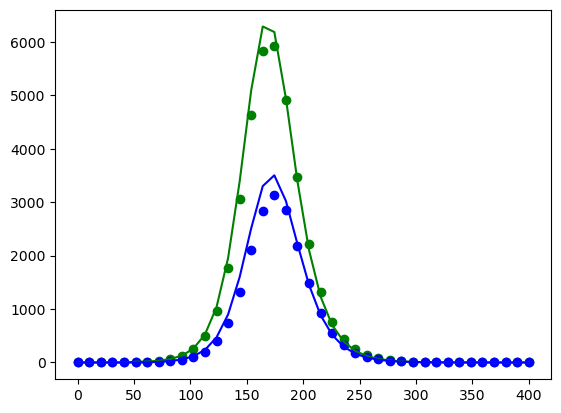

In [238]:
plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], color='green',label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], color='blue',label='Sparse Old Deaths per Day')

initial_guess_derivs = compute_derivs_per_day(t_sparse,
                                              day_of_start_0,
                                              Y_day_0_of_infection,
                                              beta_vector_0,
                                              gamma_0,
                                              delta_0,
                                              latent_period,
                                              theta_matrix_0)

plt.plot(t_sparse, initial_guess_derivs[0,3,:], color='green', label='Young initial guess')
plt.plot(t_sparse, initial_guess_derivs[1,3,:], color='blue', label='Old initial guess')

Now trying to fit properly

In [239]:
%%time

y_data = shifted_fake_deaths_per_day
sigma_y = np.maximum(np.ones(shifted_fake_deaths_per_day.shape), np.sqrt(shifted_fake_deaths_per_day))

initial_guess = [day_of_start_0, *beta_vector_0, theta_yo_0, theta_oy_0]
bounds = [(20, 80),
          (0.0, 1.0),
          (0.0, 1.0),
#          (0.01, 1.0),
#          (0.0001, 0.1),
          (0.5, 1.0),
          (0.0, 0.5)]

opt = minimize(error_function, 
               initial_guess,
               args = (t_sparse, y_data, sigma_y, gamma_0, delta_0, latent_period, Y_day_0_of_infection),
               bounds=bounds,
               tol=1e-12,
               method='Nelder-Mead',
               options={'maxiter':3000})
opt

CPU times: user 47.5 s, sys: 11.7 ms, total: 47.5 s
Wall time: 47.7 s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.355961820383328
             x: [ 4.103e+01  2.919e-01  1.701e-01  9.843e-01  3.089e-01]
           nit: 638
          nfev: 1116
 final_simplex: (array([[ 4.103e+01,  2.919e-01, ...,  9.843e-01,
                         3.089e-01],
                       [ 4.103e+01,  2.919e-01, ...,  9.843e-01,
                         3.089e-01],
                       ...,
                       [ 4.103e+01,  2.919e-01, ...,  9.843e-01,
                         3.089e-01],
                       [ 4.103e+01,  2.919e-01, ...,  9.843e-01,
                         3.089e-01]], shape=(6, 5)), array([ 4.356e+00,  4.356e+00,  4.356e+00,  4.356e+00,
                        4.356e+00,  4.356e+00]))

In [240]:
day_of_first_infection_fit, beta_fit_young, beta_fit_old, theta_yo_fit, theta_oy_fit = opt.x
gamma_fit, delta_fit = gamma_0, delta_0
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_y   = {:.3g} ,".format(beta_fit_young))
#print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_o   = {:.3g} ,".format(beta_fit_old))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit))
print("   theta_yo = {:.3g} ,".format(theta_yo_fit))
print("   theta_oy = {:.3g} ,\n".format(theta_oy_fit))

Final fitted parameters are:
   day zero = 41 ,
   beta_y   = 0.292 ,
   beta_o   = 0.17 ,
   gamma    = 0.15 ,
   delta    = 0.01 ,
   theta_yo = 0.984 ,
   theta_oy = 0.309 ,



Fit vs original data

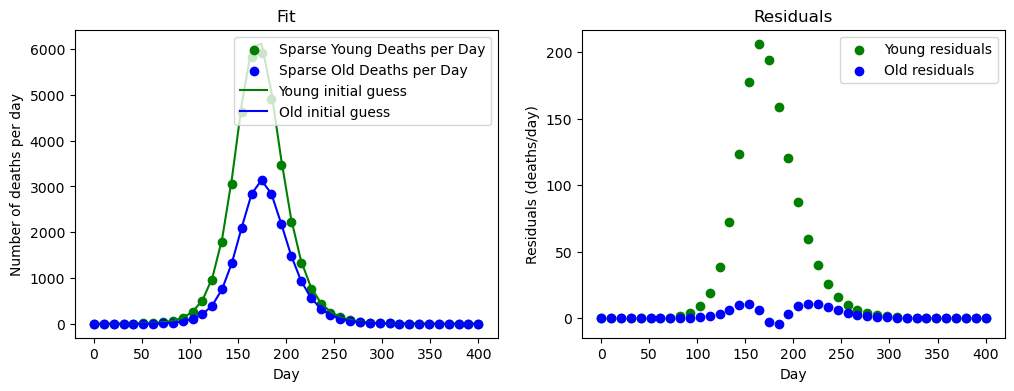

In [241]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.scatter(t_sparse, shifted_fake_deaths_per_day[0], color='green',label='Sparse Young Deaths per Day')
ax1.scatter(t_sparse, shifted_fake_deaths_per_day[1], color='blue',label='Sparse Old Deaths per Day')

theta_matrix_fit = build_theta_matrix(theta_yo_fit, theta_oy_fit)

initial_guess_derivs = compute_derivs_per_day(t_sparse,
                           day_of_first_infection_fit,
                           Y_day_0_of_infection,
                           [beta_fit_young, beta_fit_old],
                           gamma_fit,
                           delta_fit,
                           latent_period,
                           theta_matrix_fit)

ax1.plot(t_sparse, initial_guess_derivs[0,3,:], color='green', label='Young initial guess')
ax1.plot(t_sparse, initial_guess_derivs[1,3,:], color='blue', label='Old initial guess')
ax1.legend()
ax1.set_title('Fit'), ax1.set_xlabel('Day'), ax1.set_ylabel('Number of deaths per day')
ax2.scatter(t_sparse, shifted_fake_deaths_per_day[0]-initial_guess_derivs[0,3,:], color='green', label='Young residuals')
ax2.scatter(t_sparse, shifted_fake_deaths_per_day[1]-initial_guess_derivs[1,3,:], color='blue', label='Old residuals')
ax2.set_title('Residuals'), ax2.set_xlabel('Day'), ax2.set_ylabel('Residuals (deaths/day)')
ax2.legend()

# Training the model

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SIRD model on NZ data. 



In [67]:
NZ_death_data = pd.read_csv('deaths_by_age_and_date.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

,date_death,military_binary,0-19,20-49,50+,Total
0,1918-09-01 00:00:00,Y,0,1,0,1
1,1918-09-02 00:00:00,Y,0,6,0,6
2,1918-09-03 00:00:00,Y,0,4,0,4
3,1918-09-04 00:00:00,Y,0,23,0,23
4,1918-09-05 00:00:00,Y,1,15,0,16
...,...,...,...,...,...,...
147,1919-02-22 00:00:00,Y,0,2,0,2
148,1919-02-23 00:00:00,Y,0,1,0,1
149,1919-02-24 00:00:00,Y,0,2,0,2
150,1919-02-25 00:00:00,Y,0,3,0,3


In [68]:
N_0_19 , N_20_49, N_50p =  455502, 481145, 161536  # from age census data 1916
N_T = N_0_19 + N_20_49 + N_50p
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 481145 ,
Number of 50+:     161536,
     Total number :   1098183


In [71]:
dummy = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummymin = min(dummy)
x = dummy.apply(lambda l: l - dummymin).dt.days

y = NZ_death_data.sort_values('date_death')['Total']

sigma = np.maximum(np.zeros(y.shape),np.sqrt(y))

# Fitting the matrix version

Text(0.5, 1.0, 'First Guess')

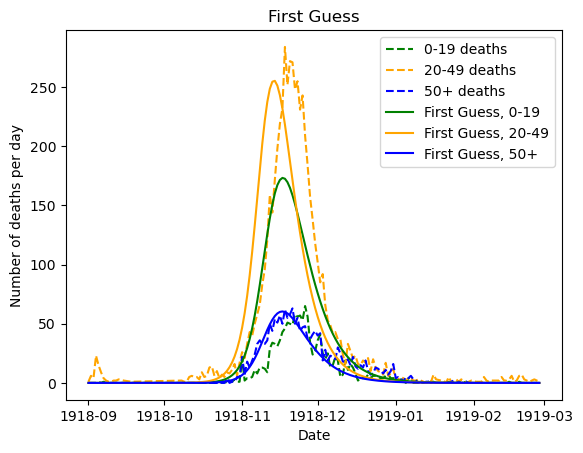

In [114]:
Y_day_0_of_infection = np.array([[455502, 0, 0, 0],
                                 [481145-100, 100, 0, 0],
                                 [161536, 0, 0, 0]])

gamma_0, delta_0 = 0.18, 0.0022
beta_vector_0 = [0.3, 0.577, 0.277]
theta_cross_0 = 0.1
theta_matrix_0 = np.array([[1-2*theta_cross_0, theta_cross_0, theta_cross_0],
                             [theta_cross_0, 1-2*theta_cross_0, theta_cross_0],
                             [theta_cross_0, theta_cross_0 , 1-2*theta_cross_0]])

day_of_first_infection_0 = 40
dates_after_start = x[x >= day_of_first_infection_0]-day_of_first_infection_0
dates_before_start = x[x < day_of_first_infection_0]


solmat = solve_ivp(deriv_matrix, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection.flatten(), 
                   args=(beta_vector_0, gamma_0, delta_0, theta_matrix_0), 
                   t_eval=dates_after_start)

total_compartments_eval = solmat.y.reshape(*Y_day_0_of_infection.shape,len(dates_after_start)).transpose((2,0,1))

my_derivs = []
for day in range(total_compartments_eval.shape[0]):
    my_derivs.append(deriv_matrix(x, total_compartments_eval[day], beta_vector_0, gamma_0, delta_0, theta_matrix_0).reshape(Y_day_0_of_infection.shape))

my_plotting_derivs = np.concatenate([np.zeros((*Y_day_0_of_infection.shape,len(dates_before_start))), np.array(my_derivs).transpose((1,2,0))],axis=2)


xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])

y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

plt.plot(xplot, y_young, 'g--', label='0-19 deaths')
plt.plot(xplot, y_mid, '--', color='orange', label='20-49 deaths')
plt.plot(xplot, y_old, 'b--', label='50+ deaths')


S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[0]
plt.plot(xplot, D_plot, 'g-', label='First Guess, 0-19')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[1]
plt.plot(xplot, D_plot, color='orange', label='First Guess, 20-49')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='First Guess, 50+')
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('First Guess')
#my_plotting_derivs.shape

In [116]:
y_data_shaped = np.array([y_young, y_mid, y_old])
y_data = y_data_shaped

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

padded_x = np.broadcast_to(x, (3,152)).flatten()

In [117]:
[day_of_first_infection_0, *beta_vector_0, gamma_0, delta_0, theta_cross_0]

[40, 0.3, 0.577, 0.277, 0.18, 0.0022, 0.1]

In [118]:
from scipy.optimize import minimize

opt = minimize(error_function, 
               [day_of_first_infection_0, *beta_vector_0, gamma_0, delta_0, theta_cross_0],
               args = (x, y_data, sigma_data, Y_day_0_of_infection),
               bounds=[(15,40),(0.2,1.0),(0.2,1.0),(0.20,1.0),(0.01,2.0),(0.0001,0.1),(0.0,1.0/3.0)],
               tol=1e-12,
               method='Nelder-Mead',
               options={'maxiter':3000})
opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 18.165984773810646
             x: [ 4.000e+01  2.000e-01  6.120e-01  5.866e-01  3.637e-01
                  6.733e-03  3.934e-02]
           nit: 598
          nfev: 1038
 final_simplex: (array([[ 4.000e+01,  2.000e-01, ...,  6.733e-03,
                         3.934e-02],
                       [ 4.000e+01,  2.000e-01, ...,  6.733e-03,
                         3.934e-02],
                       ...,
                       [ 4.000e+01,  2.000e-01, ...,  6.733e-03,
                         3.934e-02],
                       [ 4.000e+01,  2.000e-01, ...,  6.733e-03,
                         3.934e-02]], shape=(8, 7)), array([ 1.817e+01,  1.817e+01,  1.817e+01,  1.817e+01,
                        1.817e+01,  1.817e+01,  1.817e+01,  1.817e+01]))

In [121]:
day_of_first_infection_fit, beta_fit_young, beta_fit_mid, beta_fit_old, gamma_fit, delta_fit, theta_cross_fit = opt.x
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_y   = {:.3g} ,".format(beta_fit_young))
print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_o   = {:.3g} ,".format(beta_fit_old))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit))
print("   theta    = {:.3g} ,\n".format(theta_cross_fit))
print("        where the quoted uncertainty is 1 estimated standard deviation.\n")   

Final fitted parameters are:
   day zero = 40 ,
   beta_y   = 0.2 ,
   beta_m   = 0.612 ,
   beta_o   = 0.587 ,
   gamma    = 0.364 ,
   delta    = 0.00673 ,
   theta    = 0.0393 ,

        where the quoted uncertainty is 1 estimated standard deviation.



(3, 4, 152)


Text(0.5, 1.0, 'Fit')

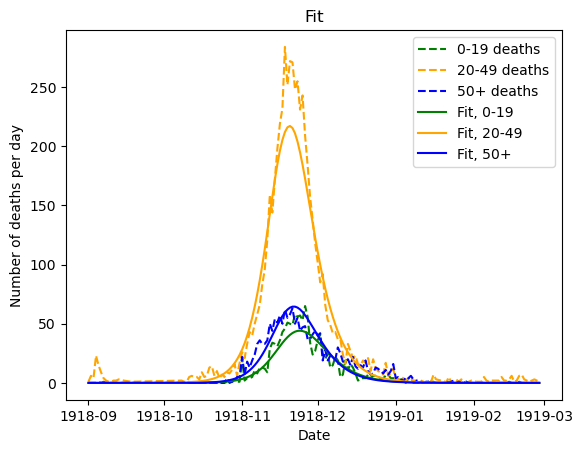

In [122]:
beta_vector_fit = [beta_fit_young, beta_fit_mid, beta_fit_old]
theta_matrix_fit = np.array([[1-2*theta_cross_fit, theta_cross_fit, theta_cross_fit],
                             [theta_cross_fit, 1-2*theta_cross_fit, theta_cross_fit],
                             [theta_cross_fit, theta_cross_fit , 1-2*theta_cross_fit]])

dates_after_start = x[x >= day_of_first_infection_fit]-day_of_first_infection_fit
dates_before_start = x[x < day_of_first_infection_fit]

solmat = solve_ivp(deriv_matrix, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection.flatten(), 
                   args=(beta_vector_fit, gamma_fit, delta_fit, theta_matrix_fit), 
                   t_eval=dates_after_start)

total_compartments_eval = solmat.y.reshape(*Y_day_0_of_infection.shape,len(dates_after_start)).transpose((2,0,1))

my_derivs = []
for day in range(total_compartments_eval.shape[0]):
    my_derivs.append(deriv_matrix(x, total_compartments_eval[day], beta_vector_fit, gamma_fit, delta_fit, theta_matrix_fit).reshape(Y_day_0_of_infection.shape))

my_plotting_derivs = np.concatenate([np.zeros((*Y_day_0_of_infection.shape,len(dates_before_start))), np.array(my_derivs).transpose((1,2,0))],axis=2)

print(my_plotting_derivs.shape)

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])

y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

plt.plot(xplot, y_young, 'g--', label='0-19 deaths')
plt.plot(xplot, y_mid, '--', color='orange', label='20-49 deaths')
plt.plot(xplot, y_old, 'b--', label='50+ deaths')


S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[0]
plt.plot(xplot, D_plot, 'g', label='Fit, 0-19')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[1]
plt.plot(xplot, D_plot, color='orange',label='Fit, 20-49')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='Fit, 50+')
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('Fit')
#my_plotting_derivs.shape